In [1]:
import sys
sys.path.append('../')
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
from systematics_module import *

%matplotlib inline

%load_ext autoreload
%autoreload 2

## systematic test 

In [2]:
import numpy as np
import healpy as hp

In [3]:
def brelchisqr(xi, xi2, invcov, brelsqr):
    DiffVector = xi2 - brelsqr*xi
    chi2 = np.dot( np.dot( DiffVector , invcov), DiffVector )
    return chi2

def find_nearest(array, value, brell):
    
    ind_min = array.argmin()
    array1 = np.asarray(array[:ind_min])
    idx1 = (np.abs(array1 - value)).argmin()
    
    array2 = np.asarray(array[ind_min:])
    idx2 = (np.abs(array2 - value)).argmin()
    
    return brell[:ind_min][idx1], brell[ind_min], brell[ind_min:][idx2]


def brel_chisqr_fitting(xi1, xi2, Fisher, verbose=False):
    
    brelsqr = np.linspace(0.8, 1.2, 5000)   
    brelarr = np.sqrt(brelsqr) 
    chisqr_result = np.zeros(brelsqr.size)
    
    i=0
    for b in brelsqr:
        chisqr_result[i] = brelchisqr(xi1, xi2, Fisher, b)
        i+=1   
        
    minarg = chisqr_result.argmin()
    chisqr_min = chisqr_result.min()
    brel = np.sqrt(brelsqr[minarg])
    
    b_cmass = 2.0
    db = b_cmass * (1. - 1./brel)
    
       
    b_cmass = 2.0

    br1, brmin, br2 = find_nearest( chisqr_result, chisqr_min + 1,brelarr )
    err_brel = np.abs(br1-br2)/2.
    err_db = err_brel *b_cmass
    if verbose : print 'err db, db / br1, brmin, br2 :', err_db, db, br1, brmin, br2  
    #return err_db, db, chisqr_result
    return err_brel, brmin, chisqr_result
    

In [4]:
# calling catalog
#from systematics import GalaxyDensity_Systematics,loadSystematicMaps, chisquare_dof, MatchHPArea, SysMapBadRegionMask, callingEliGoldMask

def calling_sysMap( properties=None, kind='SPT', nside=4096, path = None ):
    # Calling maps
    from systematics import callingEliGoldMask,callingY1GoldMask
    GoldMask = callingEliGoldMask()
    #GoldMask = callingY1GoldMask(nside)
    
    MaskDic = {}
    for i,p in enumerate(properties):
        if p == 'NSTARS_allband':
            filename =  'y1a1_gold_1.0.2_stars_nside1024.fits'
            sysMap = loadSystematicMaps( filename = filename, property = p, filter = 'g', nside = 1024 , kind = kind, path = path)
            if kind is 'STRIPE82': sysMap = sysMap[sysMap['DEC'] > -3]
            elif kind is 'SPT': sysMap = sysMap[sysMap['DEC'] < -3]
            mapname = 'sys_'+p+'_'+'g'+'_'+kind
            MaskDic[mapname] = sysMap
            
        elif p == 'GE':
            sysMap = loadSystematicMaps( property = p, filter = 'g', nside = 512 , kind = kind, path = path)
            if kind is 'STRIPE82': sysMap = sysMap[sysMap['DEC'] > -3]
            elif kind is 'SPT': sysMap = sysMap[sysMap['DEC'] < -3]
            mapname = 'sys_'+p+'_'+'g'+'_'+kind
            MaskDic[mapname] = sysMap
            
         
        else :
            filter = ['g', 'r', 'i', 'z']
            
            if p =='EXPTIME':
                filename = ['Y1A1NEW_COADD_'+kind+'_band_'+f+'_nside4096_oversamp4_EXPTIME__total.fits.gz'\
                             for f in filter ]
            elif p =='DEPTH' :
                filename = ['Y1A1NEW_COADD_'+kind+'_band_'+f+'_nside4096_oversamp4_maglimit3__.fits.gz'\
                             for f in filter ]
            elif p == 'NSTARS' : 
                filename = ['Y1A1NEW_COADD_'+kind+'_band_'+f+'_nside4096_oversamp4_NSTARS_ACCEPTED_MEAN_coaddweights3_mean.fits.gz'\
                             for f in filter ]
            else : filename = [None for f in filter]

            for j,f in enumerate(filter):
                sysMap = loadSystematicMaps( filename = filename[j], property = p, filter = f, nside = nside , kind = kind, path = path)
                mapname = 'sys_'+p+'_'+f+'_'+kind
                keep = np.in1d(sysMap['PIXEL'], GoldMask['PIXEL'])
                MaskDic[mapname] = sysMap[keep]
                
    return MaskDic

In [5]:
def maskingCatalogSP(catalog=None, sysMap=None):
    
    
    exp_i_hpind = sysMap['sys_EXPTIME_i_SPT']['PIXEL'][(sysMap['sys_EXPTIME_i_SPT']['SIGNAL'] < 500)]
    fwhm_r_hpind = sysMap['sys_FWHM_r_SPT']['PIXEL'][(sysMap['sys_FWHM_r_SPT']['SIGNAL'] < 4.5)]
    #ge_hpind = sysMap['sys_GE_g_SPT']['PIXEL'][(sysMap['sys_GE_g_SPT']['SIGNAL'] < 0.09)]
    #ge_hpind = sysMap['sys_GE_g_SPT']['PIXEL'][(sysMap['sys_GE_g_SPT']['SIGNAL'] < 100000)]
    #skybrite_g_hpind = sysMap['sys_SKYBRITE_g_SPT']['PIXEL'][(sysMap['sys_SKYBRITE_g_SPT']['SIGNAL'] < 170)]
    #skybrite_i_hpind = sysMap['sys_SKYBRITE_i_SPT']['PIXEL'][(sysMap['sys_SKYBRITE_i_SPT']['SIGNAL'] < 1400)]
    skybrite_g_hpind = sysMap['sys_SKYBRITE_g_SPT']['PIXEL'][(sysMap['sys_SKYBRITE_g_SPT']['SIGNAL'] < 1700000)]
    skybrite_i_hpind = sysMap['sys_SKYBRITE_i_SPT']['PIXEL'][(sysMap['sys_SKYBRITE_i_SPT']['SIGNAL'] < 14000000)]  
    
    all_mask1 = np.zeros( hp.nside2npix(4096), dtype=bool )
    all_mask2 = np.zeros( hp.nside2npix(4096),dtype=bool )
    all_mask3 = np.zeros( hp.nside2npix(4096),dtype=bool )
    all_mask4 = np.zeros( hp.nside2npix(4096),dtype=bool )
    
    all_mask512 = np.zeros( hp.nside2npix(512),dtype=bool )
    
    all_mask1[exp_i_hpind] = 1
    all_mask2[fwhm_r_hpind] = 1
    all_mask3[skybrite_g_hpind] = 1
    all_mask4[skybrite_i_hpind] = 1
    
    #all_mask512[ge_hpind] = 1
    all_mask512 = np.ones( hp.nside2npix(512),dtype=bool )
    all_mask4096 = all_mask1 * all_mask2 * all_mask3* all_mask4


    all_ind4096 = np.arange( hp.nside2npix(4096) )
    all_ind512 = np.arange( hp.nside2npix(512) )
    goodindices4096 = all_ind4096[all_mask4096]
    goodindices512 = all_ind512[all_mask512]
  
    
    #goodindices = np.hstack([exp_i_hpind, fwhm_r_hpind, ge_hpind])
    
    #exp_mask =  (sysMap['sys_EXPTIME_i_SPT']['SIGNAL'] < 500) &  (sysMap['sys_EXPTIME_r_SPT']['SIGNAL'] < 500)
    #fwhm_mask = ((sysMap['sys_FWHM_g_SPT']['SIGNAL'] < 500) & (sysMap['sys_FWHM_r_SPT']['SIGNAL'] < 500) 
    #            & (sysMap['sys_FWHM_i_SPT']['SIGNAL'] < 500) & (sysMap['sys_FWHM_z_SPT']['SIGNAL'] < 500))

    fwhm_mask = (sysMap['sys_FWHM_r_SPT']['SIGNAL'] < 4.5) 
    skybrite_mask = (sysMap['sys_SKYBRITE_g_SPT']['SIGNAL'] < 160) & (sysMap['sys_SKYBRITE_i_SPT']['SIGNAL'] < 1400) \
    &(sysMap['sys_SKYBRITE_z_SPT']['SIGNAL'] < 3000) 
    
    #ge_mask = (sysMap['sys_GE_g_SPT']['SIGNAL'] < 0.08)  
    #all_mask = fwhm_mask*exp_mask*skybrite_mask
    #print 'exp mask ', 1. - np.sum(exp_mask) *1./exp_mask.size
    #print 'fwhm mask', 1. - np.sum(fwhm_mask) *1./fwhm_mask.size
    #print 'skybrite mask', 1. - np.sum(skybrite_mask) *1./skybrite_mask.size
    #print 'all mask', 1. - np.sum(fwhm_mask*exp_mask*skybrite_mask) *1./fwhm_mask.size   

    catHpInd4096 = hpRaDecToHEALPixel(catalog['RA'], catalog['DEC'], nside=4096, nest=False)
    catHpInd512 = hpRaDecToHEALPixel(catalog['RA'], catalog['DEC'], nside=512, nest=False)
    HpIdxInsys_mask4096 = np.in1d(catHpInd4096, goodindices4096)
    HpIdxInsys_mask512 = np.in1d(catHpInd512, goodindices512)
    
    HpIdxInsys_mask = HpIdxInsys_mask4096 * HpIdxInsys_mask512
    
    print HpIdxInsys_mask.size, np.sum(HpIdxInsys_mask)
    print 'mask ', np.sum(HpIdxInsys_mask) * 1./catalog.size
    return catalog[HpIdxInsys_mask]
    

In [6]:
# calling map 
GoldMask = callingEliGoldMask()
#GoldMask_st82 = Cuts.SpatialCuts(GoldMask, ra=320, ra2=360, dec=-2, dec2=2)
GoldMask_st82 = GoldMask[ GoldMask['DEC'] > -3.0 ]
GoldMask_spt = GoldMask[ GoldMask['DEC'] < -3.0 ]
#GoldMask_spt = cutcat20(GoldMask_spt)
#GoldMask_spt = Cuts.SpatialCuts(GoldMask_spt, ra=0, ra2 = 100, dec=-52, dec2 = -48)

pixarea = hp.nside2pixarea( 4096, degrees = True)
sptnpix = GoldMask_spt['PIXEL'].size #hp.get_map_size( GoldMask_spt['PIXEL'] )
st82npix =  GoldMask_st82['PIXEL'].size # hp.get_map_size( GoldMask_st82 )
SPTMaparea = pixarea * sptnpix
ST82Maparea = pixarea * st82npix

In [7]:
# import DMASS

dmass = fitsio.read('../output/n2_2/dmass_spt.fits')
#dmass = cutcat20(dmass)
cmass = fitsio.read('../output/n2/dmass_st82.fits')
print 'dmass sample size :', dmass.size
print 'cmass sample size :', cmass.size

dmass sample size : 112398
cmass sample size : 11593


In [8]:
#rand_bg = uniform_random_on_sphere(dmass_spt2, size = 100 * dmass_spt2.size)
#rand_bg = Cuts.keepGoodRegion(rand_bg)
#rand_bg_train = uniform_random_on_sphere(clean_cmass_data_des, size = 100 * clean_cmass_data_des.size)
#rand_bg_train = Cuts.keepGoodRegion(rand_bg_train)

rand = uniform_random_on_sphere(dmass, size = 10 * dmass.size)
rand = Cuts.keepGoodRegion(rand)
#rand = Cuts.keepY1GoldRegion(rand)
rand = rand[ rand['DEC'] < -3.0 ]
#rand = cutcat20(rand)

rand2 = uniform_random_on_sphere(dmass, size = 50 * dmass.size)
rand2 = Cuts.keepGoodRegion(rand2)
#rand = Cuts.keepY1GoldRegion(rand)
rand2 = rand2[ rand2['DEC'] < -3.0 ]
#rand2 = cutcat20(rand2)

rand_cmass = uniform_random_on_sphere(cmass, size = 200 * cmass.size)
rand_cmass = Cuts.keepGoodRegion(rand_cmass)
rand_cmass = rand_cmass[ rand_cmass['DEC'] > -3.0 ]

rand2_cmass = uniform_random_on_sphere(cmass, size = 500 * cmass.size)
rand2_cmass = Cuts.keepGoodRegion(rand2_cmass)
rand2_cmass = rand2_cmass[ rand2_cmass['DEC'] > -3.0 ]

print rand.size, dmass.size
print rand_cmass.size, cmass.size
#rand_train = uniform_random_on_sphere(clean_cmass_data_des, size = 10 * clean_cmass_data_des.size)
#rand_train = Cuts.keepGoodRegion(rand_train)

509799 112398
188273 11593


In [15]:
rootdir ='../data_txt/systematics/mock/'
basedir = rootdir+'act/'
os.system('mkdir '+rootdir)
os.system('mkdir '+basedir)

0

In [ ]:
#tree corr
from systematics_module.corr import angular_correlation
os.system('mkdir '+basedir)
for i in range(100):
    print 'mock number', i
    dmass = fitsio.read('../output/mock/dmass_spt_{:04}.fits'.format(i+1))
    angular_correlation(data = dmass, rand = rand2, nbins=10, njack = 100, 
                        suffix = '_dmass_mock_{:04}_nbins10_jk100'.format(i+1), dir = basedir)

mock number 0
calculate angular correlation function
X (1000, 2)  centers (100, 2)  tol=1e-05  maxiter=200
14 iterations  cluster sizes: [ 7  7 13 18  3 23 10 14  9  8 15  7  8 10  8 11 12 10 11  8 18  5 16 13
  8 10 10  7 14  7 17  5 18  7  6 11 10  6 14  6 11 11 13 12  8 11  6  9
  4 14  5 23  9  8 10  8  7 11  5 17  6  4 10 10 15  3  5 14 10  9 14 12
 14 10  7  7  8  8  9 12  5  6 13  9  8  6 15  7 16  5  7 19 12  3  5 11
 10  6 11 17]
X (112398, 2)  centers (100, 2)  tol=1e-05  maxiter=200
79 iterations  cluster sizes: [1044  838 1269 1490  890  899 1521 1130  893 1172 1243 1015  913  943
 1117 1032 1379 1542 1086 1086 1169 1179  936 1211 1059 1169 1335 1016
 1345 1211  932 1003 1086 1100  621 1075  918  983 1921  917 1186 1393
 2185 1238 1029 1173  983 1039  918  936  898 1739 1124  948 1847  997
 1207 1165  903 1120 1131 1060 1115  992 1512  741  941 1524  891 1127
 1278  939 1058 1548 1054  890 1006  927 1441 1106  884  829  951 1216
  803 1072 1018 1256 1178 1211  998 1534 1212

In [ ]:

fig, ax = plt.subplots(figsize = (3,7))
brelsqr = np.linspace(0.8, 1.2, 5000) 
b_n = 2.0
brelarr = np.sqrt(brelsqr)
dbarray = b_n*(1-brelarr)

mock_num = 100
for j in range(mock_num):
    
    filename = basedir+ 'acf_auto_dmass_mock_{:04}_nbins10_jk100.txt'.format(j+1)
    covname = basedir+ 'acf_auto_dmass_mock_{:04}_nbins10_jk100.cov'.format(j+1)
    meanrw, xiw, xi_errw = np.loadtxt( filename, unpack=True)
    cov_dmass_w = np.loadtxt( covname, unpack=True)
    HFd = HF(100, 10)
    F_d = HFd * np.linalg.inv(cov_dmass_w)
    err_brelw, brelw, chisqr_resultw = brel_chisqr_fitting(xiw, theory_sgc_interp, F_d, verbose=True)
    if j == 1 : 
        color = 'red'
        ax.axvspan(2.-2*brelw - err_brelw*2., 2.-2*brelw + err_brelw*2.,  alpha=0.1, color='grey')
        ax.axvline(x=2.-2*brelw, color = 'grey', ls='--')
    else : color = 'k'  
        
    ax.errorbar(2.-2*brelw, len(labels_SP)+1-j, xerr =err_brelw*2., fmt='-o', color=color)
    
ax.set_xlabel(r'$\Delta b = b_{th} - b_x$', fontsize = 20)
#ax.set_ylabel(r'$\chi^2$')
ax.legend(loc=1)
ax.set_xlim(-0.1+0.02, 0.1+0.02)
#ax.set_yticks([1,2,3,4,5,6,7,8,9,10,11,12])
ax.set_yticks(np.arange(1, mock_num+1 ))

#ax.set_yticklabels( labels, fontsize = 15) 
fig.savefig(rootdir + 'bias_weight.png')
print 'pic save to ', rootdir + 'bias_weight.png'

# Weight 

In [9]:
kind = 'SPT'
FullArea = SPTMaparea
#def CalculteGalaxyNgal(data, ):
#properties = ['DEPTH','EXPTIME']
#properties = ['DEPTH', 'EXPTIME', 'AIRMASS', 'SKYBRITE', 'FWHM', 'NSTARS']
properties = ['DEPTH', 'EXPTIME', 'AIRMASS', 'SKYBRITE', 'FWHM', 'NSTARS_allband','GE']
#properties = ['FWHM']
suffix='no_weight'

In [11]:
# calculating galaxy density and weights iterately
sysMap = calling_sysMap( properties=properties, kind='SPT', nside=4096 )


PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_g_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_r_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_i_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_z_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_g_nside4096_oversamp4_EXPTIME__total.fits.gz

In [12]:
dmass_masked = maskingCatalogSP(catalog=dmass, sysMap=sysMap)
rand_masked = maskingCatalogSP(catalog=rand, sysMap=sysMap)
rand2_masked = maskingCatalogSP(catalog=rand2, sysMap=sysMap)

112398 108272
mask  0.9632911617644442
510791 494623
mask  0.9683471321930105
2550725 2470300
mask  0.9684697487969107


In [262]:
weightname = 'wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z_fwhm_g_airmass_g_exptime_z_exptime_g'
weightname = weightname.split('_')[1:]
order = []
for i in np.arange(0, len(weightname), 2):
    print weightname[i]+'_'+ weightname[i+1]
    order.append(weightname[i]+'_'+ weightname[i+1] )

ge_g
fwhm_r
airmass_z
skybrite_i
skybrite_r
fwhm_i
airmass_r
skybrite_z
fwhm_g
airmass_g
exptime_z
exptime_g


In [31]:
rootdir ='../data_txt/systematics/6th_include_ge/'
basedir = rootdir+'act/'
wdir = rootdir+'weights/'
os.system('mkdir '+basedir)
os.system('mkdir '+wdir)
#order = ['ge_g', 'fwhm_r', 'airmass_z', 'skybrite_i', 'airmass_g', 'fwhm_i', 'airmass_i', 'fwhm_g', 'skybrite_r', 'fwhm_z']
#order = ['fwhm_r','airmass_z', 'airmass_i', 'skybrite_i', 'skybrite_r', 'airmass_r', 'airmass_g', \
#         'nstars_allband_g', 'depth_i', 'exptime_g', 'fwhm_g', 'fwhm_z', 'exptime_z', 'depth_r', \
#         'fwhm_i', 'exptime_i', 'depth_g']
weightslist = [fitsio.read(wdir+'wg_'+o+'_SPT.fits') for o in order]
all_weight = np.ones(weightslist[0].size)
#for w in weightslist: all_weight *= w

In [32]:
os.system('cp ../data_txt/systematics/4th/act/acf_auto_dmass_nbins10_jk100.* '+basedir+'/.')
os.system('cp ../data_txt/systematics/4th/act/acf_auto_dmass_veto_nbins10_jk100.* '+basedir+'.')

0

In [264]:
angular_correlation(data = dmass, rand = rand2, nbins=10, weight = None, njack = 100, 
                        suffix = '_dmass_nbins10_jk100', dir = basedir)

calculate angular correlation function
X (1000, 2)  centers (100, 2)  tol=1e-05  maxiter=200
12 iterations  cluster sizes: [ 7  4  5 14  7  7  9  8 12  4  5  7  5  6 18 17 13 12  7  0  3  8  6  9
  5 15  7 19 13 13  8 17 10 12 10 11 18  9  7  9 15 12  8 18  5  3  8  4
 11  7 19 14 14 13 10  7  4  9 11  4 14 13 15 14  4 22 10 10  9 11 16  7
 15 12  1 12 11 15 12 12 14  9  8 14 11  8  2 11  7 14 10  5  4 12  8 13
 11 12 12  8]
X (112398, 2)  centers (100, 2)  tol=1e-05  maxiter=200
116 iterations  cluster sizes: [1027 1051  981 1273 1274  921 1229 1215  983  873 1057 1320 1067 1228
 1407 1294 1143 1149 1019 1028  951  942  983 1178 1350 1370 1165 1287
 1041 1123 1221 1191 1115 1224 1348 1068 1384 1164 1102  983 1350 1227
 1116  994 1253 1254 1178  857 1244  802 1310  870 1145 1137 1051  796
 1012 1384  937 1211 1189 1013 1181 1267  822 1192 1439 1350 1094  893
 1062  993 1131  899  910 1129  858 1559  790 1099 1403 1063 1145 1449
 1009 1060 1107 1032  894 1230 1012  959 1188 1132 1303 12

Exception KeyboardInterrupt in <bound method NNCorrelation.__del__ of NNCorrelation(config={'nbins': 10, 'split_method': 'mean', 'verbose': 1, 'min_sep': 0.041666666666666664, 'max_sep': 4.166666666666667, 'sep_units': 'deg', 'metric': 'Euclidean', 'precision': 4, 'pairwise': False, 'max_top': 10, 'm2_uform': 'Crittenden'})> ignored


 .

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/n/home00/lee.5922/.local/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/n/home00/lee.5922/.local/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/n/home00/lee.5922/.local/lib/python2.7/site-packages/IPython/core/ultratb.py", line 376, in _fixed_getinnerframes
    lines = ulinecache.getlines(file)[start:end]
  File "/n/home00/lee.5922/.local/lib/python2.7/site-packages/IPython/utils/ulinecache.py", line 37, in getlines
    return [l.decode(encoding, 'replace') for l in lines]
KeyboardInterrupt


IndexError: string index out of range

In [33]:
#tree corr
from systematics_module.corr import angular_correlation
os.system('mkdir '+basedir)
#angular_correlation(data = dmass, rand = rand2, nbins=10, weight = None, njack = 100, 
#                        suffix = '_dmass_nbins10_jk100', dir = basedir)

#angular_correlation(data = dmass_masked, rand = rand2_masked, nbins=10, weight = None, njack = 100, 
#                        suffix = '_dmass_veto_nbins10_jk100', dir = basedir)

for i in range(1,len(weightslist)+1):
    weight_com = np.ones(weightslist[0].size)
    for w in weightslist[:i]: weight_com *= w
    print i, order[i-1]
    
    angular_correlation(data = dmass_masked, rand = rand2_masked, nbins=10, weight = weight_com, njack = 100, 
                        suffix = '_dmass_weight'+str(i)+'_nbins10_jk100', dir = basedir)

1 ge_g
calculate angular correlation function
X (1000, 2)  centers (100, 2)  tol=1e-05  maxiter=200
13 iterations  cluster sizes: [12  8 11 10 11  4  9 15 10 37  5  7  7  8 10  7 12  7  8  7 14 15 11  8
  7  6 32 25 14 11  9 10  9  7  4 16 16  5 12  9 13 12  7 10  2  4  0  8
 12  7 10  4  7 13  7 12  9  9 11 13  8  4 14  9  9  8 10 10 12 12 11  8
 10 11  5  5  5  9  8 10  8  8 11  6 16 15  8 13  9 10  5 20 11 11  5  8
 11  9 12 11]
X (108272, 2)  centers (100, 2)  tol=1e-05  maxiter=200
131 iterations  cluster sizes: [1300 1509 1405 1000 1099 1080  967  897 1145 1931  653  781 1220 1043
  814  849  878  918  954 1009 1258 1192 1116  995  927  874 2253 1958
  903 1076  952  963 1144  921  819 1776 1359  868  855  868 1118 1179
  886 1205  952  725  887  914 2101  955 1133  772 1092 1130  905 2594
 1032  968  992 1101  935  749 1131 1213  907  883  926 1009 1131 1001
  856  902  676  883 1021  944 1180  822 1323 1377  951  916 1345 1078
 2012  894  994  806  897  946  896 1461 1406  903 

86 iterations  cluster sizes: [1065 1172  838 1110  834  969  858  988 1136  766 1095  972 1040  793
  763 1146 1157  964 1156  854 1163 1129 1125 1277 1421 1154  890 1221
  932 1176  616  961 1234  969 1364 1203  796  840 1220 1252 1324 1212
 1406 1298 1074 1357 1042  996  499 1175 1018 1118 1323 1108 1006  819
 1121  750 1050 1461 1145  863 1032  642 1179 1000 1220 1204 1379 1036
  910 1508  501 1194 1432 1080  790 1027 1439 1075 1407 1075 1000 1280
  841 1129 1226 1712 1120  836 1198 1294 1035  913  775 1478 1137 1013
 1237 1134]
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . saving data file to :  ../data_txt/systematics/6th_include_ge/act//acf_auto_dmass_weight7_nbins10_jk100.txt
8 skybrite_z
calculate angular correlation function
X (1000, 2)  centers (100, 2)  tol=1e-05  maxiter=200
16 iterations  cluster sizes: [12  3  6 13  8

err db, db / br1, brmin, br2 : 0.0430486225368798 -0.031578636660483994 0.9626761392440419 0.9844561091110935 1.0057247617809217
err db, db / br1, brmin, br2 : 0.043315893768491986 -0.019443745913897192 0.9684769432040722 0.9903717318428705 1.0117928369725642
err db, db / br1, brmin, br2 : 0.04348996207717393 -0.029485217893895133 0.9635069637183878 0.985471577898708 1.0069969257955618
err db, db / br1, brmin, br2 : 0.045262804093214926 -0.054521563121468386 0.9505475833127074 0.9734626474113842 0.9958103874059223
err db, db / br1, brmin, br2 : 0.048136814049466015 -0.0030073697504158226 0.9741200038785731 0.9984985727981668 1.0222568179280391
err db, db / br1, brmin, br2 : 0.044255424679410904 -0.01804486859179999 0.9686834723137929 0.9910582421269991 1.0129388969932038
err db, db / br1, brmin, br2 : 0.03955980245233004 -0.01755184080596761 0.9713231664789777 0.9913004263627961 1.0108829689313077
err db, db / br1, brmin, br2 : 0.04624779859843475 -0.032837801690568824 0.96047097868711

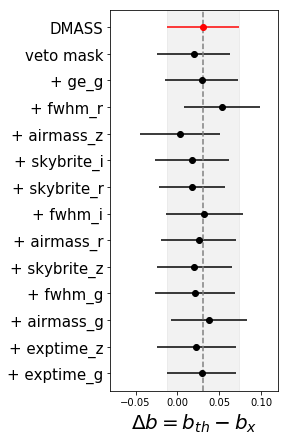

In [263]:

fig, ax = plt.subplots(figsize = (3,7))
brelsqr = np.linspace(0.8, 1.2, 5000) 
b_n = 2.0
brelarr = np.sqrt(brelsqr)
dbarray = b_n*(1-brelarr)

labels_SP = ['DMASS', 'veto mask'] + ['+ '+o for o in order ]

filenames = [ basedir+ 'acf_auto_dmass_nbins10_jk100.txt', \
              basedir + 'acf_auto_dmass_veto_nbins10_jk100.txt'] +\
[ basedir+'acf_auto_dmass_weight'+str(j)+'_nbins10_jk100.txt' for j in range(1, len(labels_SP))]

covnames = [ basedir+ 'acf_auto_dmass_nbins10_jk100.cov', \
              basedir + 'acf_auto_dmass_veto_nbins10_jk100.cov'] +\
[ basedir+'acf_auto_dmass_weight'+str(j)+'_nbins10_jk100.cov' for j in range(1, len(labels_SP))]


for j in range(1, len(labels_SP)+1):
    
    meanrw, xiw, xi_errw = np.loadtxt( filenames[j-1], unpack=True)
    cov_dmass_w = np.loadtxt( covnames[j-1], unpack=True)
    #meanrw, xiw, xi_errw = np.loadtxt(basedir+'acf_auto_dmass_weight'+str(j)+'_nbins10_jk100.txt', unpack=True)
    #cov_dmass_w = np.loadtxt(basedir+'acf_auto_dmass_weight'+str(j)+'_nbins10_jk100.cov', unpack=True)
    HFd = HF(100, 10)
    F_d = HFd * np.linalg.inv(cov_dmass_w)
    err_brelw, brelw, chisqr_resultw = brel_chisqr_fitting(xiw, theory_sgc_interp, F_d, verbose=True)
    if j == 1 : 
        color = 'red'
        ax.axvspan(2.-2*brelw - err_brelw*2., 2.-2*brelw + err_brelw*2.,  alpha=0.1, color='grey')
        ax.axvline(x=2.-2*brelw, color = 'grey', ls='--')
    else : color = 'k'  
        
    ax.errorbar(2.-2*brelw, len(labels_SP)+1-j, xerr =err_brelw*2., fmt='-o', color=color)
    
ax.set_xlabel(r'$\Delta b = b_{th} - b_x$', fontsize = 20)
#ax.set_ylabel(r'$\chi^2$')
ax.legend(loc=1)
ax.set_xlim(-0.1+0.02, 0.1+0.02)
#ax.set_yticks([1,2,3,4,5,6,7,8,9,10,11,12])
ax.set_yticks(np.arange(1, len(labels_SP)+1 ))

labels = labels_SP[::-1]
ax.set_yticklabels( labels, fontsize = 15) 
fig.savefig(rootdir + 'bias_weight.png')
print 'pic save to ', rootdir + 'bias_weight.png'




# No Galactic Extinction 

In [272]:
weightname = 'wg_fwhm_r_airmass_z_airmass_i_nstarsallband_g_skybrite_i_fwhm_g_skybrite_r_exptime_i_fwhm_z_exptime_g_exptime_z_depth_r'
weightname = weightname.split('_')[1:]
order = []
for i in np.arange(0, len(weightname), 2):   
    if weightname[i] == 'nstarsallband' : weightname[i] = 'nstars_allband'
    print weightname[i]+'_'+ weightname[i+1]
    order.append(weightname[i]+'_'+ weightname[i+1] )

fwhm_r
airmass_z
airmass_i
nstars_allband_g
skybrite_i
fwhm_g
skybrite_r
exptime_i
fwhm_z
exptime_g
exptime_z
depth_r


In [273]:
rootdir ='../data_txt/systematics/6th_ignore_ge/'
basedir = rootdir+'act/'
wdir = rootdir+'weights/'
os.system('mkdir '+basedir)
os.system('mkdir '+wdir)
#order = ['ge_g', 'fwhm_r', 'airmass_z', 'skybrite_i', 'airmass_g', 'fwhm_i', 'airmass_i', 'fwhm_g', 'skybrite_r', 'fwhm_z']
#order = ['fwhm_r','airmass_z', 'airmass_i', 'skybrite_i', 'skybrite_r', 'airmass_r', 'airmass_g', \
#         'nstars_allband_g', 'depth_i', 'exptime_g', 'fwhm_g', 'fwhm_z', 'exptime_z', 'depth_r', \
#         'fwhm_i', 'exptime_i', 'depth_g']
weightslist = [fitsio.read(wdir+'wg_'+o+'_SPT.fits') for o in order]
all_weight = np.ones(weightslist[0].size)
#for w in weightslist: all_weight *= w

In [268]:
os.system('cp ../data_txt/systematics/4th/act/acf_auto_dmass_nbins10_jk100.* '+basedir+'/.')
os.system('cp ../data_txt/systematics/4th/act/acf_auto_dmass_veto_nbins10_jk100.* '+basedir+'.')

0

In [274]:
#tree corr
from systematics_module.corr import angular_correlation
os.system('mkdir '+basedir)
#angular_correlation(data = dmass, rand = rand2, nbins=10, weight = None, njack = 100, 
#                        suffix = '_dmass_nbins10_jk100', dir = basedir)

#angular_correlation(data = dmass_masked, rand = rand2_masked, nbins=10, weight = None, njack = 100, 
#                        suffix = '_dmass_veto_nbins10_jk100', dir = basedir)

for i in range(1,len(weightslist)+1):
    weight_com = np.ones(weightslist[0].size)
    for w in weightslist[:i]: weight_com *= w
    print i, order[i-1]
    if i < 5 : pass
    else : 
        angular_correlation(data = dmass_masked, rand = rand2_masked, nbins=10, weight = weight_com, njack = 100, 
                            suffix = '_dmass_weight'+str(i)+'_nbins10_jk100', dir = basedir)

1 fwhm_r
2 airmass_z
3 airmass_i
4 nstars_allband_g
5 skybrite_i
calculate angular correlation function
X (1000, 2)  centers (100, 2)  tol=1e-05  maxiter=200
16 iterations  cluster sizes: [ 9 16 16  8 19  6  7  8  9  9  9 11  9  7 10  5 13  9 17 13 25 17  9 14
  9  2 11 14 11 13 10  7 13 14  8  8  7 19  9 11 10  5 11 11 10  9  5  6
  7  4 11 11  4  2  2  7  7 12  7  9 13 15 10 14  5  8 16 10  6  2  9  4
 16  4 10 10 12 17  8  8 13 11 10 13  9 15 12 10 12  9 12  4  9  7 11  8
  7  4 22 14]
X (108272, 2)  centers (100, 2)  tol=1e-05  maxiter=200
91 iterations  cluster sizes: [1319  814 1416 1204 1097  932 1036 1079 1280  692  580  760 1352  786
 1110  969 1066  954 1344 1116 1795 1528 1131 1022  633  883 1201 1334
 1217 1094 1204 1122 1155 1739 1156 1029  891 1245 1287  508 1084 1140
 1641 1085 1220  921  848 1025  947  563  760 1142  889  764 1407  499
  890 1185 1195  873 1461 1390  939 1185 1048  997  933 1079 1042  697
  741  697 1405  976 1269 1558  831 1170 1172 1443 1394  972  820

99 iterations  cluster sizes: [1123 1492 1228  738 1553 1739 1449  792 1468 1152 1189 1332 1213  620
  856  596  542 1088  751  578 1245  641 1821  578  755 1568  581  572
 1064 1155 1404  856 1038  588 1160 1264 1121 1488 1455 1303 1566 1807
 1061 1463  820 1104 1519  809 1244 1202  639  830  633 1063 1102 1261
 1064 1134 1552  786 1015 1406 1341  688 1352  941  871  735  554 1006
  975 1123 1306  982  914 1591 1225  553 1090  613 1478  925 1033  763
  934 1430 1246 1120  923 1313 1041  770 1873  414  498 1290  941 1935
 1100 1149]
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . saving data file to :  ../data_txt/systematics/6th_ignore_ge/act//acf_auto_dmass_weight11_nbins10_jk100.txt
12 depth_r
calculate angular correlation function
X (1000, 2)  centers (100, 2)  tol=1e-05  maxiter=200
12 iterations  cluster sizes: [16  6 11  7 11  

err db, db / br1, brmin, br2 : 0.0430486225368798 -0.031578636660483994 0.9626761392440419 0.9844561091110935 1.0057247617809217
err db, db / br1, brmin, br2 : 0.043315893768491986 -0.019443745913897192 0.9684769432040722 0.9903717318428705 1.0117928369725642
err db, db / br1, brmin, br2 : 0.04043342030733421 -0.01681297619787525 0.9712407846318782 0.9916635918172387 1.0116742049392125
err db, db / br1, brmin, br2 : 0.04667559034523816 -0.028399194483440304 0.9623851812280827 0.9859992083606242 1.0090607715733209
err db, db / br1, brmin, br2 : 0.044191803209983505 -0.041207425673777553 0.9574671527889267 0.9798122301753945 1.0016589559989102
err db, db / br1, brmin, br2 : 0.0478643527110153 -0.027148254374028902 0.9623851812280827 0.9866076621108246 1.010249533939098
err db, db / br1, brmin, br2 : 0.04408859641132379 -0.021506213254876894 0.9670713755504718 0.989361292528382 1.0111599719617956
err db, db / br1, brmin, br2 : 0.04793387130655902 -0.024902382534192746 0.9634239135123362 0

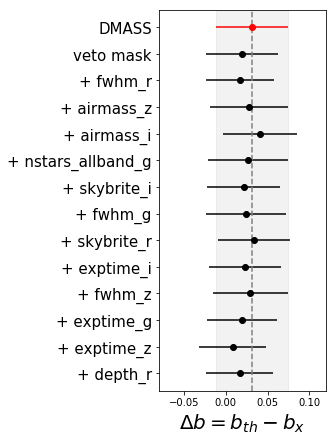

In [275]:

fig, ax = plt.subplots(figsize = (3,7))
brelsqr = np.linspace(0.8, 1.2, 5000) 
b_n = 2.0
brelarr = np.sqrt(brelsqr)
dbarray = b_n*(1-brelarr)

labels_SP = ['DMASS', 'veto mask'] + ['+ '+o for o in order ]

filenames = [ basedir+ 'acf_auto_dmass_nbins10_jk100.txt', \
              basedir + 'acf_auto_dmass_veto_nbins10_jk100.txt'] +\
[ basedir+'acf_auto_dmass_weight'+str(j)+'_nbins10_jk100.txt' for j in range(1, len(labels_SP))]

covnames = [ basedir+ 'acf_auto_dmass_nbins10_jk100.cov', \
              basedir + 'acf_auto_dmass_veto_nbins10_jk100.cov'] +\
[ basedir+'acf_auto_dmass_weight'+str(j)+'_nbins10_jk100.cov' for j in range(1, len(labels_SP))]


for j in range(1, len(labels_SP)+1):
    
    meanrw, xiw, xi_errw = np.loadtxt( filenames[j-1], unpack=True)
    cov_dmass_w = np.loadtxt( covnames[j-1], unpack=True)
    #meanrw, xiw, xi_errw = np.loadtxt(basedir+'acf_auto_dmass_weight'+str(j)+'_nbins10_jk100.txt', unpack=True)
    #cov_dmass_w = np.loadtxt(basedir+'acf_auto_dmass_weight'+str(j)+'_nbins10_jk100.cov', unpack=True)
    HFd = HF(100, 10)
    F_d = HFd * np.linalg.inv(cov_dmass_w)
    err_brelw, brelw, chisqr_resultw = brel_chisqr_fitting(xiw, theory_sgc_interp, F_d, verbose=True)
    if j == 1 : 
        color = 'red'
        ax.axvspan(2.-2*brelw - err_brelw*2., 2.-2*brelw + err_brelw*2.,  alpha=0.1, color='grey')
        ax.axvline(x=2.-2*brelw, color = 'grey', ls='--')
    else : color = 'k'  
        
    ax.errorbar(2.-2*brelw, len(labels_SP)+1-j, xerr =err_brelw*2., fmt='-o', color=color)
    

#ax.axvline(x=2.-2*brel1, color = 'grey', ls='--')
#ax.axvline(x=0, color = 'grey', ls='--')
#ax.axvspan(2.-2*brel1 - err_brel1*2., 2.-2*brel1 + err_brel1*2.,  alpha=0.1, color='k')

#ax.set_xlabel(r'$b_{rel} = b_{NGC}/b_x$', fontsize = 20)
ax.set_xlabel(r'$\Delta b = b_{th} - b_x$', fontsize = 20)
#ax.set_ylabel(r'$\chi^2$')
ax.legend(loc=1)
ax.set_xlim(-0.1+0.02, 0.1+0.02)
#ax.set_yticks([1,2,3,4,5,6,7,8,9,10,11,12])
ax.set_yticks(np.arange(1, len(labels_SP)+1 ))


#labels_SP = ['DMASS', 'veto mask']+['+ '+ o for o in order]
#labels_SP[2] = '+ galactic extinc'
#labels = ['DMASS', 'veto mask'] + labels_SP + ['']
labels = labels_SP[::-1]
ax.set_yticklabels( labels, fontsize = 15) 
fig.savefig(rootdir + 'bias_weight.png')
print 'pic save to ', rootdir + 'bias_weight.png'



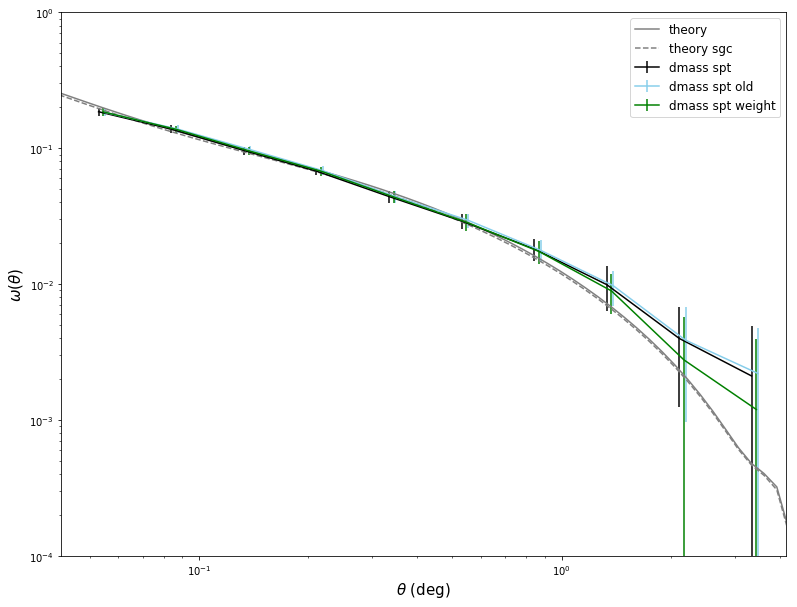

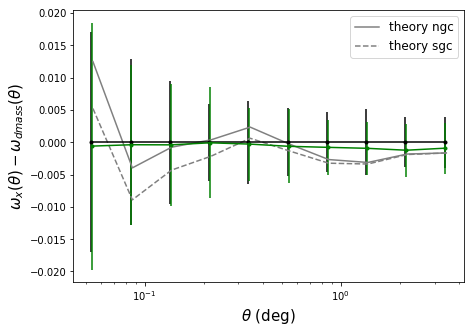

In [102]:
import scipy
meanr_old, xi_old, xi_err_old = np.loadtxt('../data_txt/acf_auto_dmass_spt_nbins10_jk100.txt',unpack=True)

theta_th, theory = np.loadtxt('../data_txt/acf_cmass_ngc_theory.txt', unpack=True)
theta_th, theory_sgc = np.loadtxt('../data_txt/acf_cmass_sgc_theory.txt', unpack=True)

#_, theory_bias = np.loadtxt('../data_txt/acf_cmass_sgc_theory_bias.txt', unpack=True)


theory_interp = scipy.interpolate.interp1d(theta_th, theory)
theory_interp = theory_interp(meanr)
theory_sgc_interp = scipy.interpolate.interp1d(theta_th, theory_sgc)
theory_sgc_interp = theory_sgc_interp(meanr)

nzs_ratio = theory_sgc_interp/theory_interp

fig, ax = plt.subplots(figsize = (13, 10))

ax.errorbar(meanr*0.97, xi, yerr = xi_err, fmt = '-', color='k', label='dmass spt')
ax.errorbar(meanr_old*1.01, xi_old, yerr = xi_err_old, fmt = '-', color='skyblue', label='dmass spt old')
ax.errorbar(meanr12, xi12, yerr = xi_err12, fmt = '-', color='green', label='dmass spt weight')
#ax.errorbar(meanr7*1.03, xi7, yerr =xi_err7, fmt = '.r', label='cmass S')
#ax.errorbar(meanr11*1.0, xi11, yerr = xi_err11, fmt = '.b', label='cmass N')

ax.plot(theta_th, theory, '-', color='grey', label='theory')
ax.plot(theta_th, theory_sgc, '--', color='grey', label='theory sgc')
#ax.plot(theta_th, theta_th*theory_bias, '--', color='green', label='theory bias')

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc = 'best', fontsize = 12)
#ax.text(1.5, 0.07, r'$\chi^2 $ = {:0.3f}  (south)'.format(chisqr), fontsize = 12)
ax.set_ylim(1e-4,1)
ax.set_xlim(2.5/60, 250./60)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 15)
ax.set_ylabel(r'$\omega(\theta)$', fontsize = 15)


fig.savefig('../figure/acf_comparison_cmass_dmass.pdf')



fig, ax = plt.subplots(figsize = (7, 5))

ax.errorbar(meanr*0.98, xi-xi, yerr = np.sqrt(2)*xi_err, fmt = '.-', color='k')
ax.errorbar(meanr*0.99, xi2-xi, yerr = np.sqrt(2)*xi_err2, fmt = '.-', color='g')
#ax.errorbar(meanr11*1.01, xi11-xi, yerr = np.sqrt(xi_err11**2+xi_err**2), fmt = '.-b', label='cmass N')
#ax.errorbar(meanr7*1.0, xi7-xi, yerr = np.sqrt(xi_err7**2+xi_err**2), fmt = '.-r', label='cmass S')

ax.plot(meanr, theory_interp -xi, '-', color='grey',label='theory ngc' )
ax.plot(meanr, theory_sgc_interp -xi, '--', color='grey', label='theory sgc' )

vdiff = xi - xi7
chisqr = np.dot(np.dot( vdiff, F_ns), vdiff)#/vdiff.size

ax.set_xscale('log')
#ax.set_yscale('log')
ax.legend(loc = 'best', fontsize = 12)
#ax.text(1.5, 0.07, r'$\chi^2 $ = {:0.3f}  (south)'.format(chisqr), fontsize = 12)
#ax.set_ylim(1e-3,)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 15)
ax.set_ylabel(r'$\omega_x(\theta)- \omega_{dmass}(\theta)$', fontsize = 15)
